[  93  328  560  790 1030 1273 1523 1773 2018 2261 2508 2761 3019 3273
 3529 3773 4022 4277 4529 4785 5033 5282 5535 5789]
240.0
False


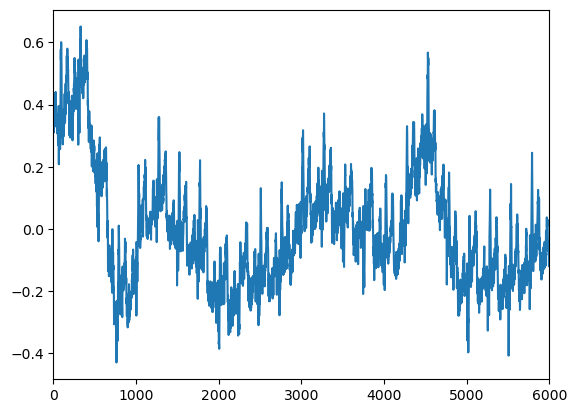

In [91]:
# ~~~~~~~~~~~~~~~ IMPORTS ~~~~~~~~~~~~~~~
from collections import Counter
import numpy as np
import os
import zipfile
import json
from pandas import *
import matplotlib.pyplot as plt
from biosppy.signals import ecg
import neurokit2 as nk

# ~~~~~~~~~~~~~~~ DATA FETCH ~~~~~~~~~~~~~~~
dir_path = '../../../../../../local1/CSE_XAI/small_data/'

# get 1 file
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    patient_X = np.empty((2, 5000))

    jsonFile = open(dir_path + path, 'r')
    fileContents = json.load(jsonFile)

    # digging into the dictionaries to get lead data
    lead_1_samples = fileContents['samples']
    lead_2_samples = fileContents['extraLeads'][0]['samples']

    # Crop the data to 6000 data points (6 seconds).
    patient_X[0,:] = lead_1_samples[0:5000]
    patient_X[1,:] = lead_2_samples[0:5000]
    count += 1
    if count == 5: # just get 1.
        break

'''
After getting a file, put it into a numpy array
Be able use the bio spy python library to get wave components from that numpy array
Output a list of wave component values with timestamp

'''
features = {"VR": None, "R": []}
frequency = fileContents["frequency"]

# smooth, straighten, and filter noise from leads for R-peak detection
filtered_lead_1 = ecg.ecg(patient_X[0], sampling_rate=frequency, show=False)[1]
filtered_lead_2 = ecg.ecg(patient_X[1], sampling_rate=frequency, show=False)[1]

# check if lead 1 is inverted
inverted = nk.ecg_invert(patient_X[0], sampling_rate=frequency, show=False)[1]

# extract r-wave peak timestamps from filtered lead I using Hamilton's algorithm
r_peaks_lead_1 = ecg.hamilton_segmenter(filtered_lead_1, sampling_rate=frequency)[0]

if inverted:
    # correct r-wave peak timestamps to fit inverted lead I (the inversion of the originally inverted lead)
    r_peaks_lead_1 = ecg.correct_rpeaks(np.negative(patient_X[0]), r_peaks_lead_1, sampling_rate=frequency)[0]
else:
    # correct r-wave peak timestamps to fit original lead I
    r_peaks_lead_1 = ecg.correct_rpeaks(patient_X[0], r_peaks_lead_1, sampling_rate=frequency)[0]

features["VR"] = len(r_peaks_lead_1) * (60 / (len(patient_X[0]) / 1000))
features["R"] = r_peaks_lead_1

print(r_peaks_lead_1)
print(features["VR"])
print(inverted)

plt.plot(patient_X[0])
plt.xlim(0, 6000)
plt.show()